**Import the libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df =  pd.read_csv('Diesel_Price_Train.csv')
df.head(5)

,Date,Delhi Diesel Price,Foreign Exchange Rate,Crude Oil Price
0,01-01-2003,19.47,48.01,29.59
1,02-01-2003,19.47,48.05,29.59
2,03-01-2003,19.07,48.00,29.59
3,04-01-2003,19.07,48.00,29.59
4,05-01-2003,19.07,48.00,29.59


**We only need Diesel price of Delhi**

In [ ]:
training_set = df[['Delhi Diesel Price']].values
training_set

array([[19.47],
       [19.47],
       [19.07],
       ...,
       [53.36],
       [53.47],
       [53.44]])

**Feature Scaling**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
sc = MinMaxScaler(feature_range=(0,1)) #Initializes the scaler to normalize features between 0 and 1.
training_scaled = sc.fit_transform(training_set) #fit() calculates the min and max values of the data, transform() scales the data to the given range using the normalization formula
training_scaled

array([[0.01001252],
       [0.01001252],
       [0.        ],
       ...,
       [0.8583229 ],
       [0.86107635],
       [0.86032541]])

**Creating a data structure**

In [ ]:
x_train = []
y_train = []

Here, the x_train will consist of the previous 120 values before each  entry in y_train. In the above snippet, we run a loop from row index 120 to 5298. Now We will start with the 121st day, whose diesel price will be recorded in the
1st row of y_train, and the corresponding diesel prices from 1st to 120th day will be recorded in the 1st row of x_train. We will follow the same procedure for all the days ranging from 121st day to 5299th day or from row index 120 to 5298.

In [ ]:
for i in range(120,  5299):
              x_train.append(training_scaled[i-120:i,0])
              y_train.append(training_scaled[i, 0])
x_train,y_train=np.array(x_train),np.array(y_train)

**Reshaping the dataset**

To pass the size of x_train as the first argument to reshape(), we use x_train.shape[0], which tells the number of rows or instances in x_train. The second parameter refers to the total number of timestamps given by the number of columns in x_train. To get the count of the total number of columns in x_train, we will use x_train.shape[1]. The third parameter refers to the total number of features or indicators we use to build our model. We use only Delhi Diesel Price as a feature or indicator, so its value will be 1.

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

**Build the architecture of RNN (import the required libraries first)**

* Sequential class: A sequential model is a stack of layers arranged above each other. Using the Sequential class, we can create a sequential model.
* Dense class: This is used for adding a regular, deeply connected neural network layer. It is used for adding the output layer.
* LSTM class: Using the LSTM class, we can add individual LSTM layers to the model. It has several parameters which can be passed while creating an instance using the LSTM() method. These are units, activation, dropout,recurrent_activation, etc.
* Dropout class: It is used for applying dropout to input. Through dropout, the randomly selected neurons are ignored during training to prevent neural networks from overfitting.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import  LSTM
from keras.layers import Dropout

**Initialize the RNN**

In [ ]:
regressor = Sequential()

**Adding the first layer of LSTM**

* Capturing the trends in diesel price is hard, we will need high dimensionality for the model. To implement these in our model we should have many neurons in each LSTM layer so no. of units have been to 50, it is important because smaller no. of neurons will not be able to capture the upward and downward trends accurately.

* Next parameter is the return_sequences, & it has been set to true because we are making stacked LSTM and we must add more layers after this.

* The third paramter is the input_shape, and we are specifying input_shape by (x_train.shape[1],1). Here, x_train.shape[1] corresponds to the number of timesteps, i.e., 120 in this case and 1 implies the number of predictors or indicators, which is 1 in our case.

* Then we specify dropout value as 0.2. It signifies that the model will drop 20% of neurons in the layer, i.e.,20% of the neurons in the LSTM layer would be ignored during the model’s training. It will help to avoid the overfitting of the model.

In [ ]:
regressor.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.2))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Adding more LSTM layers to the RNN model**

* Second layer: units(same), return_sequences(TRUE, as we will add more layers above this layer), input_shape(No need to mention this because it will be recognized automatically from the first layer)

* Third layer: same as second layer

* Fourth layer: units(same-50 neurons), return_sequences(FALSE, this is the last LSTM layer, and no more LSTM layers will be added after this layer), input_shape(no need to mention)

In [ ]:
# Second Layer
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))
# Third Layer
regressor.add(LSTM( units=50,  return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth Layer
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout( 0.2))

**Adding the output Layer**

Here we passed 1 inside Dense() to have only one node in the output layer. It is a regression model to predict prices for the next day, and also I want to predict one value as my output.

In [ ]:
regressor.add(Dense(units=1))

**Compiling the RNN**

* The Sequential class uses the compile() method for compiling
the RNN. We will call the compile() method using the regressor object by passing two arguments as input. These arguments are namely optimizer and the loss function.

* Here, we are using the adam optimizer as it is one of the most widely used and a significant performer amongst all other recommended optimizers. It implements a gradient descent algorithm as an optimizer.

* Here, we are using the mean square error for calculating the loss. As we deal with regression, the error between predicted and actual values can be measured through mean square error.

In [ ]:
regressor.compile(optimizer='adam',loss='mean_squared_error')

**Fitting the compiled RNN model into a training set**

After successful execution of this step, the corresponding loss is also decreasing with significant increase of epochs. But adverse decrement of loss will lead to overfitting, hence, the arguments are passed into fit() method.

In [ ]:
regressor.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 43s 220ms/step - loss: 0.0308
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - loss: 0.0031
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - loss: 0.0026
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 42s 252ms/step - loss: 0.0025
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 50s 308ms/step - loss: 0.0027
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 68s 224ms/step - loss: 0.0022
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - loss: 0.0020
Epoch 8/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - loss: 0.0022
Epoch 9/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - loss: 0.0020
Epoch 10/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - loss: 0.0017
Epoch 11/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 34s 212ms/step - loss: 0.0016
Epoch 12/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step - loss: 0.0015
Epoch 13/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - loss: 0.0017
Epoch 14/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - loss: 0.0015
Epoch 15/50
162

**Preparing test dataset**

In [ ]:
test_df = pd.read_csv('Diesel_Price_Test.csv')
test_df.head(5)

,Date,Delhi Diesel Price,Foreign Exchange Rate,Crude Oil Price
0,05-07-2017,53.44,64.71,47.86
1,06-07-2017,53.61,64.76,47.86
2,07-07-2017,53.82,64.78,47.86
3,08-07-2017,54.06,64.78,47.86
4,09-07-2017,54.32,64.78,47.86


Only the Delhi Diesel Price column is relevant to us out of all the columns. To extract this column, we will use the iloc[] method with two arguments “:” and “1:2”. Here, “:” means data from all the rows, and “1:2” are lower and upper bounds of the column, indicating the column selection at index 1.

In [ ]:
diesel_price = test_df.iloc[:,1:2].values

**Preparing the test data in the desired data structure for feeding it to the model**

To predict each test day, model needs 120 prior days. Combine last 120 training days with test data using concat().

Code Explanation: we concatenate train and test dataset and form a new dataframe called dataset_total, but we do not need all these records. So we choose the desired data by:

=> len(dataset_total) – len(dataset_test) – 120

=> 5379 – 80 – 120 = 5179th record (This gave us the index from which we pull the data to create the required data structure)

In the next line reshape is used to reshape the inputs and next line scaling is done as RNN was trained on scaled values.

In [ ]:
dataset_total = pd.concat((df['Delhi Diesel Price'],test_df['Delhi Diesel Price']), axis=0)
inputs = dataset_total[len(dataset_total)-len(test_df)-120:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

**Creating the desired 3D structure for test data**

This code segment iterates through the range of indices from 120 to 199, extracts a specific subset of values from the inputs array, and adds them to the x_test list for further processing.

In [ ]:
x_test = []
for i in range(120, 200):
  x_test.append(inputs[i-120:i,0])

**Coneverting x_test to array and creating 3D structure**

This code segment iterates through the range of indices from 120 to 199, extracts a specific subset of values from the inputs array, and adds them to the x_test list for further processing.

Since x_test is the list and we need to convert it into NumPy arrays, the     np.array() method will be used to convert x_test into NumPy arrays.

 Once the x_test is prepared, we will convert it into three-dimension, as the RNN model demands an input in 3D format.

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

**Making the predictions**

The first line of code will return the predictions in scaled values as our dataset is scaled, so to make it consistent with the actual diesel price, we have to inverse the scaling of our predictions.

To get the original scale of these scaled predicted values, we need to apply the inverse transform method from our scaling sc object.

After making the predictions, we used the inverse_transform() method to get back the diesel prices in a normal readable format.

In [ ]:
predicted_diesel_price=regressor.predict(x_test)
predicted_diesel_price=sc.inverse_transform(predicted_diesel_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step


**Visualize the result**

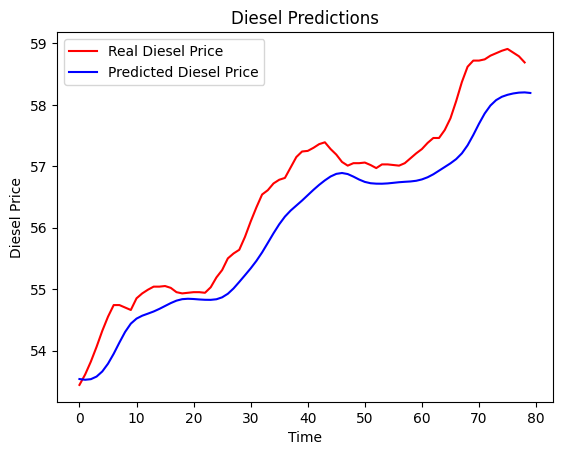

In [ ]:
plt.plot(diesel_price, color="red",label="Real Diesel Price")
plt.plot(predicted_diesel_price, color="blue",label="Predicted Diesel Price")
plt.title("Diesel Predictions")
plt.xlabel("Time")
plt.ylabel("Diesel Price")
plt.legend()
plt.savefig("DieselTS", dpi=2500)
plt.show()